In [170]:
import pandas as pd
import numpy as np
import contractions
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('averaged_perceptron_tagger')
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
import matplotlib.pyplot as plt
import seaborn as sns
import gensim
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim 
from gensim.models import LdaSeqModel
from gensim.corpora import Dictionary
from gensim import corpora, models
import numpy as np
from scipy.special import psi, polygamma

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/cep4u/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Dataset Import. Adding Time Slices

In [213]:
df = pd.read_json('News_Category_Dataset_v3.json', lines=True)

In [214]:
df['date'] = pd.to_datetime(df['date'])

In [215]:
df['quarter'] = df['date'].dt.to_period("Q")

In [216]:
time_slices = df['quarter'].value_counts().sort_index().tolist()

## DataCleaner

In [175]:
class DataCleaner:
    def __init__(self, df, column_name, stop_words, wnl ):
        self.df = df
        self.column_name = column_name
        self.stop_words = stop_words
        self.wnl = wnl
    
    def remove_null(self, df, column_name):
        df = df[df[column_name].notnull()]
        return df

    def remove_contractions(self, df, column_name):
        df[f'RemoveContractions_{column_name}'] = df[column_name].apply(lambda x: [contractions.fix(word) for word in x.split()])
        return df

    def rebuild_string(self, df, column_name):
        df[f'{column_name}_string_nocont'] = [' '.join(map(str, l)) for l in df[f'RemoveContractions_{column_name}']]
        return df

    def tokenize(self, df, column_name):
        df[f'tokenized_{column_name}'] = df[f'{column_name}_string_nocont'].apply(word_tokenize)
        return df
    
    def token_cleanup(self, df, column_name):
        edge_cases = ["``", "’", "''", "image", "title", "alt", "src", "width", "img", "http", "cbc", "jpg", "16x9_460", "buzzfeed", "com", "h1", "href", "href=", 'p', '/p', '/a' "rel", "www", "reuters", "timesofindia", "indiatimes", "margin", "nofollow", '8217', '8230']
        df[f'tokenized_{column_name}'] = df[f'tokenized_{column_name}'].apply(lambda x: [word.lower() for word in x])
        df[f'tokenized_{column_name}'] = df[f'tokenized_{column_name}'].apply(lambda x: [word for word in x if word not in string.punctuation])
        df[f'tokenized_{column_name}'] = df[f'tokenized_{column_name}'].apply(lambda x: [word for word in x if word not in self.stop_words])
        df[f'tokenized_{column_name}'] = df[f'tokenized_{column_name}'].apply(lambda x: [word for word in x if '/' not in word])
        df[f'tokenized_{column_name}'] = df[f'tokenized_{column_name}'].apply(lambda x: [word for word in x if word not in edge_cases])
        return df

    def make_bigrams(self, df, column_name):
        bigram = gensim.models.Phrases(df[f'tokenized_{column_name}'], min_count=5, threshold=100)
        bigram_mod = gensim.models.phrases.Phraser(bigram)

        def get_bigrams(tokens_list):
            return bigram_mod[tokens_list]

        df[f'bigrams_{column_name}'] = df[f'tokenized_{column_name}'].apply(get_bigrams)
        
        return df
        
    def lemmatize_tokens(self, df, column_name):
        clean_up = ["'s", "--", "—","“","”"]
        df[f'lemmatized_{column_name}'] = df[f'bigrams_{column_name}'].apply(lambda x: [self.wnl.lemmatize(word) for word in x])
        df[f'lemmatized_{column_name}'] = df[f'lemmatized_{column_name}'].apply(lambda x: [word for word in x if word not in clean_up])
        return df

    def clean(self):
        df = self.remove_null(self.df, self.column_name)
        df = self.remove_contractions(df, self.column_name)
        df = self.rebuild_string(df, self.column_name)
        df = self.tokenize(df, self.column_name)
        df = self.token_cleanup(df, self.column_name)
        df = self.make_bigrams(df, self.column_name)
        df = self.lemmatize_tokens(df, self.column_name)
        return df

## WordNetLemmatizer

In [217]:
wnl = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

desc_cleaner_news = DataCleaner(df, 'short_description', stop_words, wnl)
cleaned_df_desc = desc_cleaner_news.clean()

In [218]:
cleaned_df_desc['lemmatized_short_description']

0         [health, expert, said, early, predict, whether...
1         [subdued, passenger, crew, fled, back, aircraf...
2                           [dog, understand, could, eaten]
3         [accidentally, put, grown-up, toothpaste, todd...
4         [amy, cooper, accused, investment, firm, frank...
                                ...                        
209522    [verizon, wireless, already, promoting, lte, d...
209523    [afterward, azarenka, effusive, press, normal,...
209524    [leading, super_bowl, xlvi, talked, game, coul...
209525    [correction_earlier, version, story, incorrect...
209526    [five-time, all-star, center, tore, teammate, ...
Name: lemmatized_short_description, Length: 209527, dtype: object

## Modeler

In [178]:
class LDAModeler:
    def __init__(self, df, column_name):
        self.df = df
        self.column_name = column_name
    
    def create_corpus(self, df, column_name):
        
        id2word = corpora.Dictionary(df[f'lemmatized_{self.column_name}'])

        texts = df[f'lemmatized_{self.column_name}']

        corpus = [id2word.doc2bow(text) for text in texts]
        
        return corpus

## Create Dictionary, Texts, and Corpus

In [179]:
id2word = corpora.Dictionary(cleaned_df_desc['lemmatized_short_description'])
texts = cleaned_df_desc['lemmatized_short_description']
corpus = [id2word.doc2bow(text) for text in texts]
print(corpus[0])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1)]


## Train Models

In [194]:
bigram_lda_model_10 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

## Load Previously Trained Models

In [222]:
bigram_lda_model_3 = bigram_lda_model_5.load("bigram_lda_model_3")
bigram_lda_model_4 = bigram_lda_model_5.load("bigram_lda_model_4")
bigram_lda_model_5 = bigram_lda_model_5.load("bigram_lda_model_5")
bigram_lda_model_6 = bigram_lda_model_5.load("bigram_lda_model_6")
bigram_lda_model_7 = bigram_lda_model_5.load("bigram_lda_model_7")
bigram_lda_model_8 = bigram_lda_model_5.load("bigram_lda_model_8")
bigram_lda_model_9 = bigram_lda_model_5.load("bigram_lda_model_9")
bigram_lda_model_10 = bigram_lda_model_5.load("bigram_lda_model_10")

lda_science = bigram_lda_model_5.load("bigram_lda_model_SCIENCE")

ldaseq_5 = ldaseq_5.load("ldaseq_5")
bigram_lda_model_5 = bigram_lda_model_5.load("bigram_lda_model_5")

## Analyze Models

In [195]:
print(lda_science.print_topics())
doc_lda = bigram_lda_model_10[corpus]

[(0, '0.013*"mission" + 0.013*"one" + 0.012*"launch" + 0.011*"later" + 0.011*"northern" + 0.011*"could" + 0.011*"russian" + 0.011*"man" + 0.010*"activity" + 0.010*"50"'), (1, '0.021*"science" + 0.015*"time" + 0.012*"last" + 0.011*"year" + 0.011*"day" + 0.011*"nasa" + 0.011*"solar" + 0.011*"scientist" + 0.010*"space" + 0.009*"possible"'), (2, '0.019*"antibiotic" + 0.019*"human" + 0.015*"new" + 0.014*"study" + 0.011*"report" + 0.010*"great" + 0.010*"different" + 0.010*"word" + 0.010*"lack" + 0.010*"arm"'), (3, '0.029*"high" + 0.015*"mean" + 0.014*"space_station" + 0.014*"aurora" + 0.014*"president" + 0.013*"faster" + 0.013*"latitude" + 0.011*"space.com" + 0.010*"even" + 0.009*"look"'), (4, '0.019*"photo" + 0.016*"researcher" + 0.016*"1" + 0.015*"evolution" + 0.014*"seen" + 0.013*"earth" + 0.012*"borealis" + 0.010*"moon" + 0.008*"see" + 0.008*"found"')]


In [223]:
tp_mod_coh = CoherenceModel(model=bigram_lda_model_10, texts= cleaned_df_desc['lemmatized_short_description'], dictionary=id2word, coherence='c_v')
tp_mod_sc = tp_mod_coh.get_coherence()
print('\nCoherence Score: ', tp_mod_sc)


Coherence Score: 0.2891055713636538


## Visualize LDA

In [185]:
models = [bigram_lda_model_3,bigram_lda_model_4,bigram_lda_model_5,bigram_lda_model_6,bigram_lda_model_7,bigram_lda_model_8,bigram_lda_model_9,bigram_lda_model_10]
coh = []
for model in models:
    bigram_coherence_model_lda = CoherenceModel(model=model, texts= cleaned_df_desc['lemmatized_short_description'], dictionary=id2word, coherence='c_v')
    bigram_coherence_lda = bigram_coherence_model_lda.get_coherence()
    coh.append(bigram_coherence_lda)

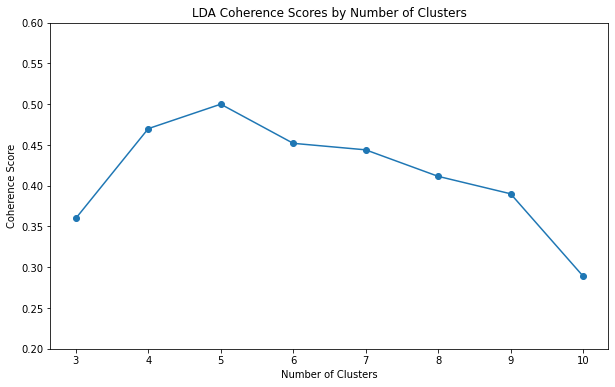

In [187]:
clusters = list(range(3, 11))

plt.figure(figsize=(10, 6))
plt.plot(clusters, coh, marker='o')

plt.title('LDA Coherence Scores by Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Coherence Score')
plt.ylim(0.2, 0.6)
plt.savefig('LDA coherence_scores_by_number_of_clusters.png')
plt.show()

## 10 Cluster LDA

In [197]:
pyLDAvis.enable_notebook()
bigram_vis_10 = pyLDAvis.gensim.prepare(bigram_lda_model_10, corpus, id2word)
bigram_vis_10

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.184547 -0.184975       1        1  15.826311
4     -0.336946  0.209084       2        1  15.550556
2     -0.098356 -0.302702       3        1  12.762332
7     -0.000546  0.227138       4        1  12.359749
9      0.082741  0.015200       5        1   9.343574
1      0.061681 -0.016869       6        1   9.131296
6      0.089812  0.013253       7        1   6.906419
5      0.116764  0.005378       8        1   6.802153
8      0.139669  0.015596       9        1   5.960034
0      0.129727  0.018898      10        1   5.357577, topic_info=           Term          Freq         Total Category  logprob  loglift
144         one  16935.000000  16935.000000  Default  30.0000  30.0000
86          day  11340.000000  11340.000000  Default  29.0000  29.0000
197        time  13061.000000  13061.000000  Default  28.0000  28.0000
37         like  10795.000000  10795.000000  Default  27.0000  27.0000
160        week   8559.000000   8559.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
186        wife    912.693313    913.477987  Topic10  -4.8447   2.9258
1616    quality    822.308133    823.092868  Topic10  -4.9490   2.9257
80    interview    790.391290    791.175979  Topic10  -4.9886   2.9257
1647  available    783.830224    784.614930  Topic10  -4.9969   2.9257
4063   watching    773.472370    774.257098  Topic10  -5.0102   2.9256

[331 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
3708      1  0.999545        ...
375       6  0.999380         10
7974      3  0.999805       2012
17        9  0.999863  according
8614      5  0.999487    actress
...     ...       ...        ...
137       2  0.999857      world
15        2  0.999899      would
122       3  0.999946       year
1475      1  0.999852        yet
16        7  0.999407      you.s

[302 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 5, 3, 8, 10, 2, 7, 6, 9, 1])

## Analyze DTM

In [199]:
df = pd.read_json('News_Category_Dataset_v3.json', lines=True)
df['date'] = pd.to_datetime(df['date'])
df['Quarter'] = df['date'].dt.to_period("Q")
time_slices = df['Quarter'].value_counts().sort_index().tolist()
df = df[df['Quarter'] >= '2021-01']

In [200]:
wnl = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
desc_cleaner_news = DataCleaner(df, 'short_description', stop_words, wnl)
cleaned_df_desc = desc_cleaner_news.clean()

In [201]:
id2word = corpora.Dictionary(cleaned_df_desc['lemmatized_short_description'])
texts = cleaned_df_desc['lemmatized_short_description']
corpus = [id2word.doc2bow(text) for text in texts]
print(corpus[0])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1)]


In [202]:
def extract_topics(ldaseq_model, time_slice, topn=10):
    topics_at_time = ldaseq_model.print_topics(time=time_slice, top_terms=topn)
    return [[id2word.token2id[word] for word, _ in topic] for topic in topics_at_time]

In [207]:
from gensim.models.coherencemodel import CoherenceModel

topics_dtm =  ldaseq_5.dtm_coherence(time=2)
cm_DTM = CoherenceModel(topics=topics_dtm, texts=texts, dictionary=id2word, coherence='c_v')

print ("C_v topic coherence")
print ("DTM Python coherence is", cm_DTM.get_coherence())

C_v topic coherence
DTM Python coherence is 0.25761271461018076


In [205]:
ldaseq_5.print_topics(time=2)

[[('said', 0.011809425283001726),
  ('actor', 0.00475976407053803),
  ('new', 0.004553589030787536),
  ('way', 0.004348531807960837),
  ('president', 0.0041398554529723285),
  ('state', 0.004094667342099061),
  ('made', 0.0040127310212044725),
  ('star', 0.003955542046699252),
  ('told', 0.0038758747926041885),
  ('year', 0.0037851105935289855),
  ('show', 0.0036970260837769875),
  ('trump', 0.0035489740712636208),
  ('people', 0.0035137566598621183),
  ('one', 0.003506675171552086),
  ('health', 0.003408730660777689),
  ('life', 0.003390163565975213),
  ('world', 0.003295976359491694),
  ('make', 0.003225533904524319),
  ('war', 0.0030743382991250336),
  ('back', 0.0028376755371129526)],
 [('president', 0.005349854501192007),
  ('biden', 0.004578960387830168),
  ('former', 0.004231650351238807),
  ('one', 0.0040899498202552785),
  ('year', 0.004086817266401977),
  ('people', 0.004037663290352302),
  ('also', 0.003984457486761929),
  ('said', 0.0038659698060351643),
  ('new', 0.0037467

In [208]:
doc = ldaseq_5.doc_topics(140)
print(doc)

[6.64451827e-04 1.35225270e-01 6.64451827e-04 6.64451827e-04
 8.62781374e-01]


## Visualize DTM

In [209]:
doc_topic, topic_term, doc_lengths, term_frequency, vocab = ldaseq_5.dtm_vis(time=0, corpus=corpus)
vis_wrapper = pyLDAvis.prepare(topic_term_dists=topic_term, doc_topic_dists=doc_topic, doc_lengths=doc_lengths, vocab=vocab, term_frequency=term_frequency)
pyLDAvis.display(vis_wrapper)

## Categorical Analysis

In [210]:
cats = ['TECH', 'SPORTS', 'ENTERTAINMENT', 'POLITICS', 'WEIRD NEWS',
       'ENVIRONMENT', 'EDUCATION', 'CRIME', 'SCIENCE', 'WELLNESS',
       'BUSINESS', 'STYLE & BEAUTY', 'FOOD & DRINK', 'MEDIA',
       'QUEER VOICES', 'HOME & LIVING', 'WOMEN', 'BLACK VOICES', 'TRAVEL',
       'MONEY', 'RELIGION']

for cat in cats:
    df = pd.read_json('News_Category_Dataset_v3.json', lines=True)
    df = df[df['category'] == cat]
    wnl = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))

    desc_cleaner_news = DataCleaner(df, 'short_description', stop_words, wnl)
    cleaned_df_desc = desc_cleaner_news.clean()
        # Create Dictionary
    id2word = corpora.Dictionary(cleaned_df_desc['lemmatized_short_description'])

    # Create Corpus
    texts = cleaned_df_desc['lemmatized_short_description']

    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]
    tp_mod = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
    
    print(cat)
    # Compute Perplexity
    print('\nPerplexity: ', tp_mod.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

    # Compute Coherence Score
    tp_mod_coh = CoherenceModel(model=tp_mod, texts= cleaned_df_desc['lemmatized_short_description'], dictionary=id2word, coherence='c_v')
    tp_mod_sc = tp_mod_coh.get_coherence()
    print('\nCoherence Score: ', tp_mod_sc)
    print('------------------')

TECH

Perplexity:  -9.07930790722985

Coherence Score:  0.42051567907221266
------------------
SPORTS

Perplexity:  -9.494707125653667

Coherence Score:  0.369272701310683
------------------
ENTERTAINMENT

Perplexity:  -9.707721086840019

Coherence Score:  0.2961121408600636
------------------
POLITICS

Perplexity:  -9.34584120259523

Coherence Score:  0.4068725642768368
------------------
WEIRD NEWS

Perplexity:  -9.317921612048345

Coherence Score:  0.5167106045677361
------------------
ENVIRONMENT

Perplexity:  -9.02438572588592

Coherence Score:  0.4376982189097404
------------------
EDUCATION

Perplexity:  -8.521927701263916

Coherence Score:  0.38033668563799267
------------------
CRIME

Perplexity:  -9.248667152903963

Coherence Score:  0.4713933772669635
------------------
SCIENCE

Perplexity:  -9.314006867106485

Coherence Score:  0.46532119063151534
------------------
WELLNESS

Perplexity:  -8.876995129335228

Coherence Score:  0.25945750420561675
------------------
BUSINESS


In [224]:
cat = 'SCIENCE'
df = pd.read_json('News_Category_Dataset_v3.json', lines=True)
df = df[df['category'] == cat]
wnl = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

desc_cleaner_news = DataCleaner(df, 'short_description', stop_words, wnl)
cleaned_df_desc = desc_cleaner_news.clean()
    # Create Dictionary
id2word = corpora.Dictionary(cleaned_df_desc['lemmatized_short_description'])

# Create Corpus
texts = cleaned_df_desc['lemmatized_short_description']

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
tp_mod = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=5, 
                                       random_state=100,
                                       update_every=1,
                                       chunksize=100,
                                       passes=10,
                                       alpha='auto',
                                       per_word_topics=True)

print(cat)
# Compute Perplexity
print('\nPerplexity: ', tp_mod.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
tp_mod_coh = CoherenceModel(model=tp_mod, texts= cleaned_df_desc['lemmatized_short_description'], dictionary=id2word, coherence='c_v')
tp_mod_sc = tp_mod_coh.get_coherence()
print('\nCoherence Score: ', tp_mod_sc)
print('------------------')
tp_mod.save("bigram_lda_model_SCIENCE")

SCIENCE

Perplexity:  -9.314006867106485

Coherence Score:  0.46532119063151534
------------------
